In [1]:
import glob
import ntpath
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report, multilabel_confusion_matrix

%matplotlib inline

In [34]:
path = os.getcwd()
reports_path = os.path.join(path, '../../reports')

In [3]:
files_true = glob.glob(path + '/data_true/*.xlsx')
files_pred = glob.glob(path + '/data_pred/*.xlsx')

In [4]:
df_true = pd.DataFrame()
for f in files_true:
    data = pd.read_excel(f, engine='openpyxl')
    data = data[['Entity', 'Label']]
    df_true = df_true.append(data)

In [5]:
filenames_true = {ntpath.basename(file) for file in files_true}
df_pred = pd.DataFrame()
for f in files_pred:
    if ntpath.basename(f) in filenames_true:
        data = pd.read_excel(f, engine='openpyxl')
        data = data[['Entity', 'Label']]
        df_pred = df_pred.append(data)

In [6]:
df_true = df_true[df_true['Entity'].notna()]

In [7]:
df_true.shape

(54, 2)

In [8]:
df_pred.shape

(246, 2)

In [9]:
df = pd.merge(df_true, df_pred, on=['Entity'], how='outer').drop_duplicates().fillna("O")

In [10]:
df.columns = ['Entity', 'y_true', 'y_pred']

In [11]:
df.shape

(45, 3)

In [12]:
y_true = df.iloc[:, 1]

In [13]:
y_pred = df.iloc[:, 2]

### Métriques globales

In [14]:
accuracy_score(y_true, y_pred)

0.7555555555555555

In [15]:
recall_score(y_true, y_pred, average="macro")

0.8042735042735043

In [16]:
precision_score(y_true, y_pred, average="macro")

0.8623737373737375

In [17]:
f1_score(y_true, y_pred, average="macro")

0.8226495726495726

### Métriques par entité

In [37]:
classes = np.unique(y_true)
classes = classes.tolist()
report = classification_report(y_true, y_pred, labels=classes)

In [38]:
%%capture report_capture --no-stderr
print(report)

In [39]:
print(report_capture.stdout)

               precision    recall  f1-score   support

         DATE       1.00      1.00      1.00         1
        EMAIL       1.00      1.00      1.00         3
FAMILY_STATUS       1.00      1.00      1.00         1
         LANG       1.00      1.00      1.00         1
          LOC       0.64      0.54      0.58        13
            O       0.12      0.20      0.15         5
          PER       1.00      0.50      0.67         2
      PERIODE       1.00      1.00      1.00        17
          TEL       1.00      1.00      1.00         2

     accuracy                           0.76        45
    macro avg       0.86      0.80      0.82        45
 weighted avg       0.80      0.76      0.77        45




In [43]:
with open(os.path.join(reports_path, 'classification.txt'), 'w') as report_file:
    report_file.write(report_capture.stdout)

### Matrice de confusion

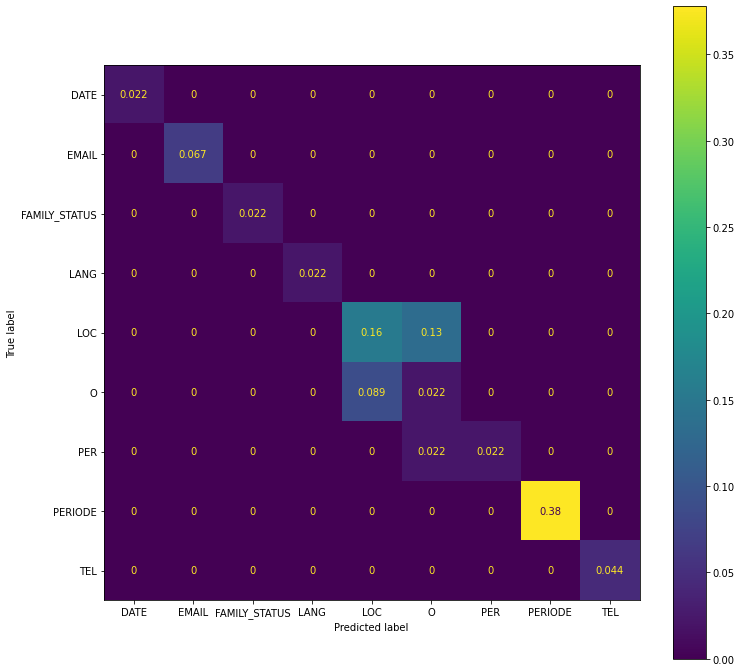

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix = confusion_matrix(y_true, y_pred, labels=classes, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=classes)
_, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

### Erreurs détectées par label

In [21]:
regex_list = ['TEL', 'PERIODE', 'EMAIL', 'LANG', 'URL', 'DATE']
regex_error_count = 0
model_list = ['PER', 'LOC']
model_error_count = 0

In [22]:
dict_error_regex = {}
dict_error_model = {}
df_error = df.loc[(df['y_true'] != df['y_pred'])]

In [23]:
for item in df['y_true'].unique():
    if (((len(df_error.loc[df_error['y_true'] == item]) > 0) | (len(df_error.loc[df_error['y_pred'] == item]) > 0)) & (
            item != 'O')):
        if (item in regex_list):
            regex_error_count = regex_error_count + len(
                df_error.loc[(df_error['y_true'] == item) | (df_error['y_pred'] == item)])
            dict_error_regex[item] = len(df_error.loc[(df_error['y_true'] == item) | (df_error['y_pred'] == item)])
        else:
            model_error_count = model_error_count + len(
                df_error.loc[(df_error['y_true'] == item) | (df_error['y_pred'] == item)])
            dict_error_model[item] = len(df_error.loc[(df_error['y_true'] == item) | (df_error['y_pred'] == item)])

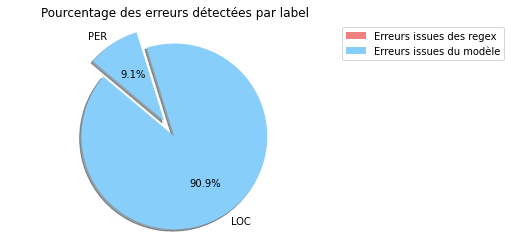

In [24]:
nbr_regex_colors = ['lightcoral'] * len(dict_error_regex.values())
nbr_model_colors = ['lightskyblue'] * len(dict_error_model.values())
labels = list(dict_error_regex.keys()) + list(dict_error_model.keys())
sizes = list(dict_error_regex.values()) + list(dict_error_model.values())
colors = nbr_regex_colors + nbr_model_colors
explode = [0.1] * len(nbr_regex_colors + nbr_model_colors)
plt.pie(sizes, labels=labels, colors=colors, explode=explode,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Pourcentage des erreurs détectées par label')
plt.axis('equal')
plt.legend([
    Patch(facecolor='lightcoral'),
    Patch(facecolor='lightskyblue')
], ["Erreurs issues des regex", "Erreurs issues du modèle"], bbox_to_anchor=[1.5, 1],
    loc='upper right', ncol=1)
plt.show()